In [318]:
import pandas as pd
import collections

import numpy as np
import matplotlib.pyplot as plt
import folium as fo
import json
from bokeh.io import show,  output_notebook
from bokeh.plotting import figure
from bokeh.models import LabelSet,Legend
output_notebook()
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

Loading BokehJS ...

In [35]:
df=pd.read_parquet('resources/cleaned_franchises.parquet')
df['Results'] = (df['Results'] == 'Fail')
df = df.rename(columns={'Results': 'Fails'})
df.head()

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Fails,...,Re-inspection,Community,Neighborhood,Ward,Precinct,Violation IDs,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
Inspection ID,,,,,,,,,,,,,,,,,,,,,
2320519,SALAM RESTAURANT,SALAMRESTAURANT,2002822,Restaurant,High,4634-4636 N KEDZIE AVE,60625,2019-10-25,Complaint,False,...,True,ALBANY PARK,"NORTH PARK,ALBANY PARK",33,27,[None],0,0,0,0
2320509,TAQUERIA EL DORADO,TAQUERIAELDORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,True,...,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,"[3, 5, 25, 50, 53, 53, 56, 58]",8,2,1,5
2320412,"DANTE'S PIZZA,INC.",DANTESPIZZA,2092884,Restaurant,High,3028 W ARMITAGE AVE,60647,2019-10-24,Canvass,True,...,False,LOGAN SQUARE,LOGAN SQUARE,32,22,"[38, 47, 53, 55, 58, 60]",6,0,0,6
2320430,LAO PENG YOU LLC,LAOPENGYOU,2694477,Restaurant,High,2020 W CHICAGO,60622,2019-10-24,License,False,...,True,WEST TOWN,UKRAINIAN VILLAGE AND EAST VILLAGE,2,21,"[3, 48, 51, 55, 58]",5,1,0,4
2320384,ARBOR,ARBOR,2363029,Restaurant,High,2545 W DIVERSEY AVE,60647,2019-10-24,Others,False,...,False,LOGAN SQUARE,LOGAN SQUARE,32,1,"[14, 25, 41, 47, 48, 55, 56, 57, 58, 60]",10,1,1,8


In [3]:
nb_licenses_by_aka_dict = {}
for name in df['AKA Name'].unique():
    nb_uniques = len(df[df['AKA Name'] == name].groupby('License #'))
    nb_licenses_by_aka_dict[name] = nb_uniques
nb_licenses_by_aka = pd.DataFrame(nb_licenses_by_aka_dict.items(), columns=['AKA Name', 'Nb Licenses']).set_index('AKA Name').sort_values('Nb Licenses', ascending=False)
nb_licenses_by_aka.head()

,Nb Licenses
AKA Name,
SUBWAY,465
7ELEVEN,324
DUNKINDONUTS,305
STARBUCKS,255
MCDONALDS,202


In [26]:
nb_licenses_by_aka.head(10)

,Nb Licenses
AKA Name,
SUBWAY,465
7ELEVEN,324
DUNKINDONUTS,305
STARBUCKS,255
MCDONALDS,202
BURGERKING,121
KFC,99
CITGO,91
HAROLDSCHICKEN,84


In [5]:
nb_inspections_by_aka = df[['AKA Name', 'DBA Name']].groupby('AKA Name').count().rename(columns={'DBA Name' : 'Nb Inspections'}).sort_values('Nb Inspections', ascending=False)
nb_passed_inspections_by_aka = df[df['Results'] == 'Pass'][['AKA Name', 'Results']].groupby('AKA Name').count().rename(columns={'Results' : 'Nb Passed Inspections'})
nb_failed_inspections_by_aka = df[df['Results'] == 'Fail'][['AKA Name', 'Results']].groupby('AKA Name').count().rename(columns={'Results' : 'Nb Failed Inspections'})
mean_nb_violations_by_aka = df[['AKA Name', 'Nb Violations']].groupby('AKA Name').mean().rename(columns={'Nb Violations' : 'Mean Nb Violations'})
mean_nb_high_violations_by_aka = df[['AKA Name', 'Nb Violations of high severity']].groupby('AKA Name').mean().rename(columns={'Nb Violations of high severity' : 'Mean Nb Violations of high severity'})
mean_nb_medium_violations_by_aka = df[['AKA Name', 'Nb Violations of medium severity']].groupby('AKA Name').mean().rename(columns={'Nb Violations of medium severity' : 'Mean Nb Violations of medium severity'})
mean_nb_low_violations_by_aka = df[['AKA Name', 'Nb Violations of low severity']].groupby('AKA Name').mean().rename(columns={'Nb Violations of low severity' : 'Mean Nb Violations of low severity'})

In [6]:
def retrieve_violation_ids(serie):
    result = {}
    for violation_ids in serie:
        for violation_id in violation_ids:
            if violation_id != 'None':
                violation_id = int(violation_id)
                if violation_id in result:
                    result[violation_id] += 1
                else:
                    result[violation_id] = 1
    return collections.OrderedDict(sorted(result.items()))

violations_ids_by_aka = df[['AKA Name', 'Violation IDs']].groupby('AKA Name').agg(lambda x: retrieve_violation_ids(x)).rename(columns={'Violation IDs' : 'Dist Violation IDs'})
violations_ids_by_aka.head(10)

,Dist Violation IDs
AKA Name,
1000LIQUORSBIGCITYTAP,"{3: 2, 4: 1, 5: 2, 10: 1, 12: 1, 16: 3, 21: 1,..."
1021MONTROSE,{}
1030SUNDRY,{}
103RDCITGOINC,{}
106HALSTED,{}
10PINBOWLINGLOUNGE,"{2: 2, 3: 1, 4: 1, 5: 1, 10: 1, 16: 1, 18: 1, ..."
1104WABASH,"{34: 1, 35: 1, 38: 2}"
111COFFEEBAR,"{2: 1, 3: 2, 5: 1, 23: 1, 36: 1, 37: 1, 47: 1,..."
111CONCESSIONSHOP,{}


In [7]:
def retrieve_inspections_types(serie):
    result = {}
    for inspection_type in serie:
        if inspection_type in result:
            result[inspection_type] += 1
        else:
            result[inspection_type] = 1
    return collections.OrderedDict(sorted(result.items()))
    
inspections_types_by_aka = df[['AKA Name', 'Inspection Type']].groupby('AKA Name').agg(lambda x: retrieve_inspections_types(x)).rename(columns={'Inspection Type' : 'Dist Inspections Types'})
inspections_types_by_aka.head()

,Dist Inspections Types
AKA Name,
1000LIQUORSBIGCITYTAP,"{'Canvass': 7, 'Complaint': 5}"
1021MONTROSE,{'Canvass': 1}
1030SUNDRY,"{'Canvass': 1, 'License': 1}"
103RDCITGOINC,{'Canvass': 1}
106HALSTED,{'License': 1}


In [67]:
df_joined = nb_inspections_by_aka.join(nb_licenses_by_aka).join(nb_passed_inspections_by_aka.join(nb_failed_inspections_by_aka)).join(mean_nb_violations_by_aka.join(mean_nb_high_violations_by_aka).join(mean_nb_medium_violations_by_aka).join(mean_nb_low_violations_by_aka)).join(violations_ids_by_aka).join(inspections_types_by_aka)
df_joined['Mean Nb Inspections'] = df_joined['Nb Inspections'] / df_joined['Nb Licenses']
df_joined['Mean Percent Passed Inspections'] = ((df_joined['Nb Passed Inspections'] / df_joined['Nb Licenses']) / df_joined['Mean Nb Inspections'] * 100).fillna(0.0)
df_joined['Mean Percent Failed Inspections'] = 100 - df_joined['Mean Percent Passed Inspections']
df_joined = df_joined.drop(['Nb Passed Inspections', 'Nb Failed Inspections'], axis=1)

def size_category(nb_addresses):
    if nb_addresses >= 100:
        return 'Huge'
    if nb_addresses >= 20:
        return 'Large'
    elif nb_addresses >= 5:
        return 'Medium'
    else:
        return 'Small'
    
df_joined['Size'] = df_joined['Nb Licenses'].map(size_category)

df_joined.head(10)

,Nb Inspections,Nb Licenses,Mean Nb Violations,Mean Nb Violations of high severity,Mean Nb Violations of medium severity,Mean Nb Violations of low severity,Dist Violation IDs,Dist Inspections Types,Mean Nb Inspections,Mean Percent Passed Inspections,Mean Percent Failed Inspections,Size
AKA Name,,,,,,,,,,,,
SUBWAY,4107,465,2.551741,0.310933,0.283175,1.957633,"{1: 27, 2: 171, 3: 475, 4: 12, 5: 224, 6: 56, ...","{'Cancelled': 4, 'Canvass': 3096, 'Complaint':...",8.832258,59.045532,40.954468,Huge
DUNKINDONUTS,2357,305,3.039881,0.267289,0.310140,2.462452,"{1: 17, 2: 95, 3: 186, 4: 3, 5: 79, 6: 53, 7: ...","{'Cancelled': 7, 'Canvass': 1375, 'Complaint':...",7.727869,61.009758,38.990242,Huge
MCDONALDS,2080,202,3.030288,0.227404,0.230288,2.572596,"{1: 3, 2: 61, 3: 132, 4: 7, 5: 46, 6: 30, 7: 1...","{'Cancelled': 6, 'Canvass': 584, 'Complaint': ...",10.297030,65.096154,34.903846,Huge
STARBUCKS,1427,255,2.188507,0.180799,0.203924,1.803784,"{1: 6, 2: 29, 3: 80, 4: 2, 5: 54, 6: 3, 7: 1, ...","{'Canvass': 1007, 'Complaint': 188, 'Consultat...",5.596078,67.063770,32.936230,Huge
7ELEVEN,1396,324,3.014327,0.304441,0.279370,2.430516,"{1: 5, 2: 68, 3: 153, 4: 1, 5: 74, 6: 10, 7: 2...","{'Cancelled': 1, 'Canvass': 1001, 'Complaint':...",4.308642,55.659026,44.340974,Huge
BURGERKING,751,121,3.213049,0.270306,0.316911,2.625832,"{1: 2, 2: 17, 3: 60, 4: 2, 5: 36, 6: 10, 7: 1,...","{'Cancelled': 1, 'Canvass': 266, 'Complaint': ...",6.206612,54.993342,45.006658,Huge
POPEYES,678,64,3.525074,0.314159,0.237463,2.973451,"{1: 5, 2: 19, 3: 69, 4: 1, 5: 57, 6: 6, 8: 4, ...","{'Cancelled': 2, 'Canvass': 303, 'Complaint': ...",10.593750,63.864307,36.135693,Large
POTBELLYSANDWICH,596,48,3.288591,0.266779,0.253356,2.768456,"{1: 1, 2: 28, 3: 54, 4: 2, 5: 27, 6: 8, 8: 2, ...","{'Canvass': 481, 'Complaint': 88, 'Consultatio...",12.416667,66.442953,33.557047,Large
HAROLDSCHICKEN,576,84,3.461806,0.307292,0.352431,2.802083,"{1: 4, 2: 28, 3: 56, 5: 30, 6: 7, 9: 2, 10: 20...","{'Cancelled': 1, 'Canvass': 171, 'Complaint': ...",6.857143,52.256944,47.743056,Large


In [68]:
nb_violations = df.set_index('AKA Name')
nb_violations = nb_violations.loc[['MCDONALDS','BURGERKING','KFC','HAROLDSCHICKEN']]
nb_violations = nb_violations.reset_index()
nb_violations = nb_violations.drop(['License #','Zip','Latitude','Longitude','Re-inspection'],axis=1)
nb_violations = nb_violations.groupby('AKA Name').sum()
nb_violations = nb_violations.sort_values('Nb Violations', ascending=False)
nb_violations = nb_violations.join(nb_licenses_by_aka.loc[['MCDONALDS','BURGERKING','KFC','HAROLDSCHICKEN']])
nb_violations.head()

,Fails,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity,Nb Licenses
AKA Name,,,,,,
MCDONALDS,360.0,6303,473,479,5351,202
BURGERKING,120.0,2413,203,238,1972,121
HAROLDSCHICKEN,134.0,1994,177,203,1614,84
KFC,92.0,1834,129,138,1567,99


In [329]:
df_mc = df[df['AKA Name']== 'MCDONALDS']
df_bk = df[df['AKA Name']== 'BURGERKING']
df_kfc = df[df['AKA Name']== 'KFC']
df_hc = df[df['AKA Name']== 'HAROLDSCHICKEN']
df_sw = df[df['AKA Name']== 'SUBWAY']
df_ps = df[df['AKA Name']== 'POTBELLYSANDWICH']

In [70]:
df_mc.head()

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Fails,...,Re-inspection,Community,Neighborhood,Ward,Precinct,Violation IDs,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
Inspection ID,,,,,,,,,,,,,,,,,,,,,
2315844,McDonald's #4308,MCDONALDS,1904304,Restaurant,Medium,3867 S Archer AVE,60632,2019-10-15,Canvass,False,...,False,BRIGHTON PARK,"BRIGHTON PARK,MCKINLEY PARK",12,17,"[10, 16, 55]",3,1,1,1
2315658,MCDONALD'S,MCDONALDS,2542078,Restaurant,Medium,4946 N MILWAUKEE AVE,60630,2019-10-10,Complaint,False,...,False,JEFFERSON PARK,JEFFERSON PARK,45,20,[None],0,0,0,0
2313189,McDonalds,MCDONALDS,1984911,Restaurant,Medium,4320 N Cicero AVE,60641,2019-10-02,Complaint,False,...,True,PORTAGE PARK,PORTAGE PARK,45,12,"[36, 47, 51, 56]",4,0,0,4
2313143,MCDONALDS #4655,MCDONALDS,33146,Restaurant,Medium,4334 W 26TH ST,60623,2019-10-01,Complaint,False,...,True,SOUTH LAWNDALE,LITTLE VILLAGE,22,6,[None],0,0,0,0
2313076,MCDONALD'S #5293,MCDONALDS,2694085,Unknown,Medium,8321 S ASHLAND AVE,60620,2019-09-27,License,False,...,False,AUBURN GRESHAM,AUBURN GRESHAM,21,13,[None],0,0,0,0


In [71]:
df_bk.head()

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Fails,...,Re-inspection,Community,Neighborhood,Ward,Precinct,Violation IDs,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
Inspection ID,,,,,,,,,,,,,,,,,,,,,
2315773,BURGER KING #11967,BURGERKING,2368805,Restaurant,Medium,2401-2407 W OGDEN AVE,60608,2019-10-11,Canvass,False,...,False,NEAR WEST SIDE,"LITTLE ITALY, UIC",28,11,[55],1,0,0,1
2311497,BURGER KING #14476,BURGERKING,2368808,Restaurant,Medium,6950 S PULASKI RD,60629,2019-08-29,Canvass,False,...,False,WEST LAWN,WEST LAWN,13,46,"[10, 36, 49, 55, 55]",5,1,0,4
2311495,BURGER KING #10366,BURGERKING,2368802,Restaurant,Medium,4060 S PULASKI RD,60632,2019-08-29,Canvass,False,...,False,ARCHER HEIGHTS,"ARCHER HEIGHTS,WEST ELSDON",14,2,"[5, 55]",2,1,0,1
2311429,BURGER KING #215,BURGERKING,2368736,Restaurant,Medium,6261-6265 N LINCOLN AVE,60659,2019-08-28,Canvass,False,...,True,NORTH PARK,"NORTH PARK,ALBANY PARK",50,25,[None],0,0,0,0
2305036,BURGER KING #215,BURGERKING,2368736,Restaurant,Medium,6261-6265 N LINCOLN AVE,60659,2019-08-21,Canvass,True,...,False,NORTH PARK,"NORTH PARK,ALBANY PARK",50,25,"[2, 56, 56, 56, 60]",5,1,0,4


In [72]:
df_kfc.head()

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Fails,...,Re-inspection,Community,Neighborhood,Ward,Precinct,Violation IDs,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
Inspection ID,,,,,,,,,,,,,,,,,,,,,
2303698,KFC,KFC,2153034,Restaurant,High,3536-3538 N CICERO AVE,60641,2019-07-25,Canvass,False,...,False,PORTAGE PARK,PORTAGE PARK,31,12,"[2, 5, 10, 36, 39, 40, 47, 49, 51, 55, 57, 58]",12,3,0,9
2301033,KENTUCKY FRIED CHICKEN,KFC,2565166,Restaurant,High,3927 N HARLEM AVE,60634,2019-07-12,Canvass,False,...,False,DUNNING,DUNNING,38,3,"[3, 5, 10, 55, 58]",5,3,0,2
2300905,KFC,KFC,2157629,Restaurant,High,4713-4717 W FULLERTON AVE,60639,2019-07-10,Canvass,False,...,False,BELMONT CRAGIN,"BELMONT CRAGIN,HERMOSA",36,11,"[3, 5, 10, 10, 49, 55, 57, 60]",8,4,0,4
2300782,KENTUCKY FRIED CHICKEN,KFC,2483753,Restaurant,High,7508 S LAFAYETTE AVE,60620,2019-07-08,Complaint,False,...,True,GREATER GRAND CROSSING,"SOUTH SHORE, GRAND CROSSING",6,19,[None],0,0,0,0
2300683,KENTUCKY FRIED CHICKEN,KFC,2483753,Restaurant,High,7508 S LAFAYETTE AVE,60620,2019-07-05,Complaint,True,...,True,GREATER GRAND CROSSING,"SOUTH SHORE, GRAND CROSSING",6,19,"[10, 47, 49, 51, 54, 55, 55, 55, 59]",9,1,0,8


Inspection ID
2303698    False
2301033    False
2300905    False
2300782    False
2300683     True
           ...  
124330     False
70327      False
68154      False
164289     False
78255      False
Name: Fails, Length: 564, dtype: bool

In [73]:
df_hc.head()

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Fails,...,Re-inspection,Community,Neighborhood,Ward,Precinct,Violation IDs,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
Inspection ID,,,,,,,,,,,,,,,,,,,,,
2316204,HAROLD'S CHICKEN SHACK #55,HAROLDSCHICKEN,24698,Restaurant,Medium,100 W 87TH ST,60620,2019-10-21,Complaint,False,...,True,CHATHAM,"CHATHAM,BURNSIDE",21,31,[57],1,0,0,1
2315802,HAROLD'S CHICKEN SHACK #55,HAROLDSCHICKEN,24698,Restaurant,Medium,100 W 87TH ST,60620,2019-10-11,Complaint,True,...,False,CHATHAM,"CHATHAM,BURNSIDE",21,31,"[5, 47, 49, 54, 55, 56, 57, 60]",8,1,0,7
2315551,HAROLD'S CHICKEN #88,HAROLDSCHICKEN,2693894,Restaurant,Low,1450 S MICHIGAN AVE,60605,2019-10-08,License,False,...,False,NEAR SOUTH SIDE,NEAR SOUTH SIDE,3,34,[None],0,0,0,0
2312991,HAROLD'S CHICKEN & FAMILY,HAROLDSCHICKEN,2463460,Restaurant,Medium,1208 W 111TH ST,60643,2019-09-26,Canvass,False,...,False,MORGAN PARK,"MOUNT GREENWOOD,MORGAN PARK",34,32,[None],0,0,0,0
2311852,HAROLD'S CHICKEN SHACK #14,HAROLDSCHICKEN,2423269,Restaurant,Medium,1208 E 53RD ST,60615,2019-09-05,Complaint,False,...,True,HYDE PARK,HYDE PARK,4,1,[None],0,0,0,0


Text(0.5, 1.0, 'Mean of inspections by year for each MCDONALDS restaurant')

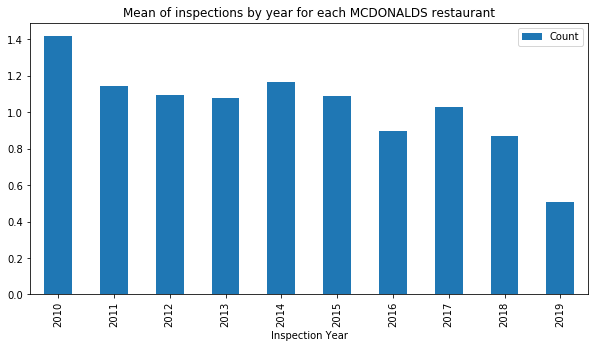

In [277]:
nb_inspections_by_year_mc = df_mc[['Inspection Date', 'License #']].copy()
nb_inspections_by_year_mc['Inspection Date'] = nb_inspections_by_year_mc['Inspection Date'].apply(lambda x: x.year)
nb_inspections_by_year_mc.rename(columns={'Inspection Date' : 'Inspection Year'}, inplace=True)
nb_inspections_by_year_mc = nb_inspections_by_year_mc.groupby('Inspection Year').count().rename(columns={'License #' : 'Count'})
nb_inspections_by_year_mc.Count = nb_inspections_by_year_mc.Count/nb_licenses_by_aka.loc["MCDONALDS","Nb Licenses"]
nb_inspections_by_year_mc.plot.bar()
plt.title("Mean of inspections by year for each MCDONALDS restaurant")

Text(0.5, 1.0, 'Number of inspections by year for BURGERKING')

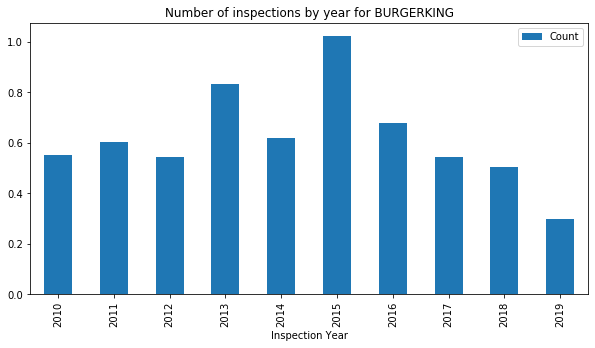

In [280]:
nb_inspections_by_year_bk = df_bk[['Inspection Date', 'License #']].copy()
nb_inspections_by_year_bk['Inspection Date'] = nb_inspections_by_year_bk['Inspection Date'].apply(lambda x: x.year)
nb_inspections_by_year_bk.rename(columns={'Inspection Date' : 'Inspection Year'}, inplace=True)
nb_inspections_by_year_bk = nb_inspections_by_year_bk.groupby('Inspection Year').count().rename(columns={'License #' : 'Count'})
nb_inspections_by_year_bk.Count = nb_inspections_by_year_bk.Count/nb_licenses_by_aka.loc["BURGERKING","Nb Licenses"]
nb_inspections_by_year_bk.plot.bar()
plt.title("Number of inspections by year for BURGERKING")


Text(0.5, 1.0, 'Number of inspections by year for KFC')

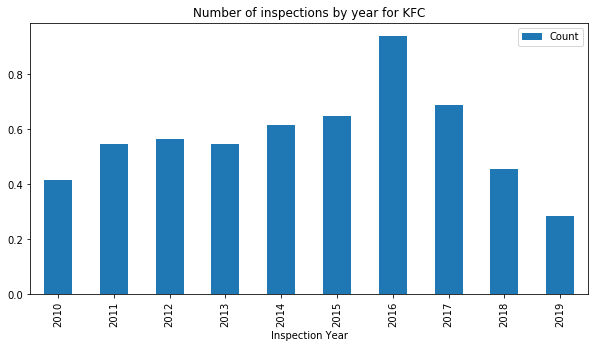

In [281]:
nb_inspections_by_year_kfc = df_kfc[['Inspection Date', 'License #']].copy()
nb_inspections_by_year_kfc['Inspection Date'] = nb_inspections_by_year_kfc['Inspection Date'].apply(lambda x: x.year)
nb_inspections_by_year_kfc.rename(columns={'Inspection Date' : 'Inspection Year'}, inplace=True)
nb_inspections_by_year_kfc = nb_inspections_by_year_kfc.groupby('Inspection Year').count().rename(columns={'License #' : 'Count'})
nb_inspections_by_year_kfc.Count = nb_inspections_by_year_kfc.Count/nb_licenses_by_aka.loc["KFC","Nb Licenses"]
nb_inspections_by_year_kfc.plot.bar()
plt.title("Number of inspections by year for KFC")

Text(0.5, 1.0, 'Number of inspections by year for HAROLDSCHICKEN')

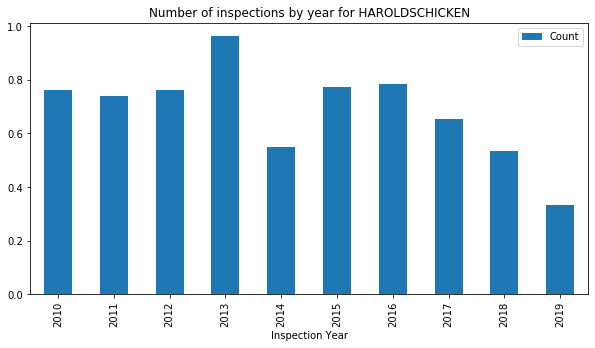

In [282]:
nb_inspections_by_year_hc = df_hc[['Inspection Date', 'License #']].copy()
nb_inspections_by_year_hc['Inspection Date'] = nb_inspections_by_year_hc['Inspection Date'].apply(lambda x: x.year)
nb_inspections_by_year_hc.rename(columns={'Inspection Date' : 'Inspection Year'}, inplace=True)
nb_inspections_by_year_hc = nb_inspections_by_year_hc.groupby('Inspection Year').count().rename(columns={'License #' : 'Count'})
nb_inspections_by_year_hc.Count = nb_inspections_by_year_hc.Count/nb_licenses_by_aka.loc["HAROLDSCHICKEN","Nb Licenses"]
nb_inspections_by_year_hc.plot.bar()
plt.title("Number of inspections by year for HAROLDSCHICKEN")

Text(0.5, 1.0, 'Mean of inspections by year for each SUBWAY restaurant')

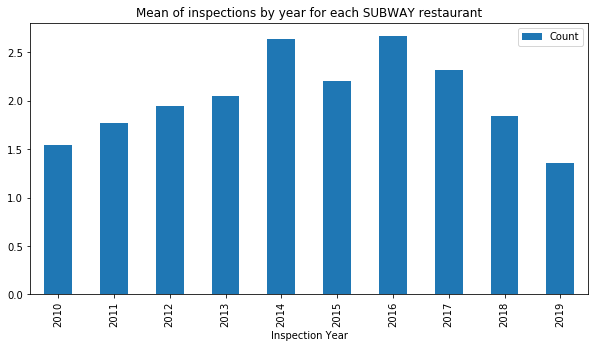

In [330]:
nb_inspections_by_year_sw = df_sw[['Inspection Date', 'License #']].copy()
nb_inspections_by_year_sw['Inspection Date'] = nb_inspections_by_year_sw['Inspection Date'].apply(lambda x: x.year)
nb_inspections_by_year_sw.rename(columns={'Inspection Date' : 'Inspection Year'}, inplace=True)
nb_inspections_by_year_sw = nb_inspections_by_year_sw.groupby('Inspection Year').count().rename(columns={'License #' : 'Count'})
nb_inspections_by_year_sw.Count = nb_inspections_by_year_sw.Count/nb_licenses_by_aka.loc["SUBWAY","Nb Licenses"]
nb_inspections_by_year_sw.plot.bar()
plt.title("Mean of inspections by year for each SUBWAY restaurant")

Text(0.5, 1.0, 'Mean of inspections by year for each POTBELLYSANDWICH restaurant')

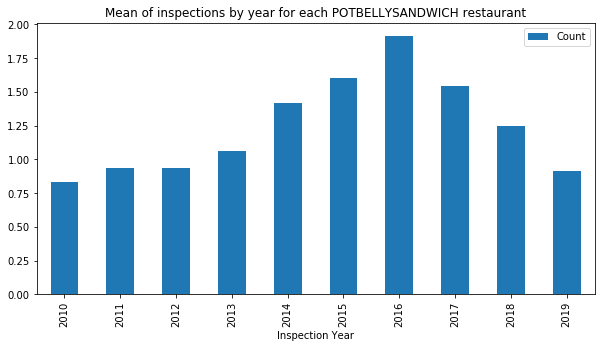

In [332]:
nb_inspections_by_year_ps = df_ps[['Inspection Date', 'License #']].copy()
nb_inspections_by_year_ps['Inspection Date'] = nb_inspections_by_year_ps['Inspection Date'].apply(lambda x: x.year)
nb_inspections_by_year_ps.rename(columns={'Inspection Date' : 'Inspection Year'}, inplace=True)
nb_inspections_by_year_ps = nb_inspections_by_year_ps.groupby('Inspection Year').count().rename(columns={'License #' : 'Count'})
nb_inspections_by_year_ps.Count = nb_inspections_by_year_ps.Count/nb_licenses_by_aka.loc['POTBELLYSANDWICH',"Nb Licenses"]
nb_inspections_by_year_ps.plot.bar()
plt.title("Mean of inspections by year for each POTBELLYSANDWICH restaurant")

In [370]:
col_to_drop=['DBA Name',
 'AKA Name',
 'Facility Type',
 'Violations',
 'License #',
 'Risk',
 'Address',
 'Zip',
 'Inspection Type',
 'Latitude',
 'Longitude',
 'Re-inspection',
 'Community',
 'Neighborhood',
 'Ward',
 'Precinct',
 'Violation IDs']
Sum = agg_year_mc.Inspections + agg_year_bk.Inspections +agg_year_kfc.Inspections + agg_year_hc.Inspections + agg_year_sw.Inspections +agg_year_ps.Inspections
col_to_rename= {'Nb Violations of high severity': 'high', 'Nb Violations of medium severity': 'medium', 'Nb Violations of low severity': 'low'}

Inspection Date
2010     811
2011     822
2012     845
2013     919
2014    1017
2015     995
2016    1054
2017     939
2018     759
2019     513
Name: Inspections, dtype: int64
Inspection Date
2010    287
2011    231
2012    221
2013    218
2014    235
2015    220
2016    181
2017    208
2018    176
2019    103
Name: Inspections, dtype: int64


In [140]:
df_mc_violations = df_mc.drop(col_to_drop,axis=1).rename(columns =col_to_rename)
df_mc_violations ['Inspections'] = 1
df_mc_violations ['Inspection Date'] = df_mc_violations ['Inspection Date'].apply(lambda x: x.year)
df_mc_violations  = df_mc_violations .set_index('Inspection Date')
df_mc_violations .head()

,Fails,Nb Violations,high,medium,low,Inspections
Inspection Date,,,,,,
2019,False,3,1,1,1,1
2019,False,0,0,0,0,1
2019,False,4,0,0,4,1
2019,False,0,0,0,0,1
2019,False,0,0,0,0,1


In [374]:
agg_year_mc = df_mc_violations.groupby('Inspection Date').agg(sum)
agg_year_mc['high'] = agg_year_mc.high / agg_year_mc['Nb Violations']
agg_year_mc['medium'] = agg_year_mc.medium / agg_year_mc['Nb Violations']
agg_year_mc['low'] = agg_year_mc.low / agg_year_mc['Nb Violations']
agg_year_mc['inspection_fail_rate'] = agg_year_mc.Fails / agg_year_mc.Inspections
agg_year_mc['Mean inspections']=nb_inspections_by_year_mc.Count
agg_year_mc.head()

,Fails,Nb Violations,high,medium,low,Inspections,inspection_fail_rate,Mean inspections
Inspection Date,,,,,,,,
2010,50.0,816,0.056373,0.064951,0.878676,287,0.174216,1.420792
2011,42.0,839,0.032181,0.075089,0.892729,231,0.181818,1.143564
2012,35.0,682,0.042522,0.089443,0.868035,221,0.158371,1.094059
2013,31.0,614,0.055375,0.066775,0.877850,218,0.142202,1.079208
2014,49.0,684,0.064327,0.096491,0.839181,235,0.208511,1.163366


In [347]:
df_bk_violations = df_bk.drop(col_to_drop,axis=1).rename(columns =col_to_rename)
df_bk_violations ['Inspections'] = 1
df_bk_violations ['Inspection Date'] = df_bk_violations ['Inspection Date'].apply(lambda x: x.year)
df_bk_violations  = df_bk_violations.set_index('Inspection Date')
df_bk_violations.head()

,Fails,Nb Violations,high,medium,low,Inspections
Inspection Date,,,,,,
2019,False,1,0,0,1,1
2019,False,5,1,0,4,1
2019,False,2,1,0,1,1
2019,False,0,0,0,0,1
2019,True,5,1,0,4,1


In [361]:
agg_year_bk = df_bk_violations.groupby('Inspection Date').agg(sum)
agg_year_bk['high'] = agg_year_bk.high / agg_year_bk['Nb Violations']
agg_year_bk['medium'] = agg_year_bk.medium / agg_year_bk['Nb Violations']
agg_year_bk['low'] = agg_year_bk.low / agg_year_bk['Nb Violations']
agg_year_bk['inspection_fail_rate'] = agg_year_bk.Fails / agg_year_bk.Inspections
agg_year_bk['Mean inspections']=nb_inspections_by_year_bk.Count
agg_year_bk.head()

,Fails,Nb Violations,high,medium,low,Inspections,inspection_fail_rate,Mean inspections
Inspection Date,,,,,,,,
2010,3.0,212,0.042453,0.056604,0.900943,67,0.044776,0.553719
2011,8.0,241,0.041494,0.070539,0.887967,73,0.109589,0.603306
2012,11.0,274,0.069343,0.116788,0.813869,66,0.166667,0.545455
2013,19.0,303,0.042904,0.135314,0.821782,101,0.188119,0.834711
2014,13.0,233,0.038627,0.107296,0.854077,75,0.173333,0.619835


In [349]:
df_kfc_violations = df_kfc.drop(col_to_drop,axis=1).rename(columns =col_to_rename)
df_kfc_violations ['Inspections'] = 1
df_kfc_violations ['Inspection Date'] = df_kfc_violations ['Inspection Date'].apply(lambda x: x.year)
df_kfc_violations  = df_kfc_violations.set_index('Inspection Date')
df_kfc_violations.head()

,Fails,Nb Violations,high,medium,low,Inspections
Inspection Date,,,,,,
2019,False,12,3,0,9,1
2019,False,5,3,0,2,1
2019,False,8,4,0,4,1
2019,False,0,0,0,0,1
2019,True,9,1,0,8,1


In [362]:
agg_year_kfc = df_kfc_violations.groupby('Inspection Date').agg(sum)
agg_year_kfc['high'] = agg_year_kfc.high / agg_year_kfc['Nb Violations']
agg_year_kfc['medium'] = agg_year_kfc.medium / agg_year_kfc['Nb Violations']
agg_year_kfc['low'] = agg_year_kfc.low / agg_year_kfc['Nb Violations']
agg_year_kfc['inspection_fail_rate'] = agg_year_kfc.Fails / agg_year_kfc.Inspections
agg_year_kfc['Mean inspections']=nb_inspections_by_year_kfc.Count
agg_year_kfc.head()

,Fails,Nb Violations,high,medium,low,Inspections,inspection_fail_rate,Mean inspections
Inspection Date,,,,,,,,
2010,5.0,147,0.061224,0.061224,0.877551,41,0.121951,0.414141
2011,8.0,224,0.058036,0.071429,0.870536,54,0.148148,0.545455
2012,9.0,180,0.083333,0.061111,0.855556,56,0.160714,0.565657
2013,10.0,185,0.037838,0.124324,0.837838,54,0.185185,0.545455
2014,12.0,190,0.036842,0.089474,0.873684,61,0.196721,0.616162


In [351]:
df_hc_violations = df_hc.drop(col_to_drop,axis=1).rename(columns =col_to_rename)
df_hc_violations['Inspections'] = 1
df_hc_violations['Inspection Date'] = df_hc_violations['Inspection Date'].apply(lambda x: x.year)
df_hc_violations = df_hc_violations.set_index('Inspection Date')
df_hc_violations.head()

,Fails,Nb Violations,high,medium,low,Inspections
Inspection Date,,,,,,
2019,False,1,0,0,1,1
2019,True,8,1,0,7,1
2019,False,0,0,0,0,1
2019,False,0,0,0,0,1
2019,False,0,0,0,0,1


In [363]:
agg_year_hc = df_hc_violations.groupby('Inspection Date').agg(sum)
agg_year_hc['high'] = agg_year_hc.high / agg_year_hc['Nb Violations']
agg_year_hc['medium'] = agg_year_hc.medium / agg_year_hc['Nb Violations']
agg_year_hc['low'] = agg_year_hc.low / agg_year_hc['Nb Violations']
agg_year_hc['inspection_fail_rate'] = agg_year_hc.Fails / agg_year_hc.Inspections
agg_year_hc['Mean inspections']=nb_inspections_by_year_hc.Count
agg_year_hc.head()

,Fails,Nb Violations,high,medium,low,Inspections,inspection_fail_rate,Mean inspections
Inspection Date,,,,,,,,
2010,17.0,163,0.042945,0.085890,0.871166,64,0.265625,0.761905
2011,15.0,251,0.055777,0.071713,0.872510,62,0.241935,0.738095
2012,10.0,156,0.051282,0.089744,0.858974,64,0.156250,0.761905
2013,19.0,226,0.053097,0.159292,0.787611,81,0.234568,0.964286
2014,9.0,199,0.050251,0.095477,0.854271,46,0.195652,0.547619


In [353]:
df_sw_violations = df_sw.drop(col_to_drop,axis=1).rename(columns =col_to_rename)
df_sw_violations['Inspections'] = 1
df_sw_violations['Inspection Date'] = df_sw_violations['Inspection Date'].apply(lambda x: x.year)
df_sw_violations = df_sw_violations.set_index('Inspection Date')
df_sw_violations.head()

,Fails,Nb Violations,high,medium,low,Inspections
Inspection Date,,,,,,
2019,False,2,0,0,2,1
2019,False,2,0,0,2,1
2019,False,0,0,0,0,1
2019,True,3,0,0,3,1
2019,False,9,2,0,7,1


In [364]:
agg_year_sw = df_sw_violations.groupby('Inspection Date').agg(sum)
agg_year_sw['high'] = agg_year_sw.high / agg_year_sw['Nb Violations']
agg_year_sw['medium'] = agg_year_sw.medium / agg_year_sw['Nb Violations']
agg_year_sw['low'] = agg_year_sw.low / agg_year_sw['Nb Violations']
agg_year_sw['inspection_fail_rate'] = agg_year_sw.Fails / agg_year_sw.Inspections
agg_year_sw['Mean inspections']=nb_inspections_by_year_sw.Count
agg_year_sw.head()

,Fails,Nb Violations,high,medium,low,Inspections,inspection_fail_rate,Mean inspections
Inspection Date,,,,,,,,
2010,57.0,709,0.052186,0.081805,0.866008,312,0.182692,1.544554
2011,48.0,890,0.061798,0.095506,0.842697,357,0.134454,1.767327
2012,40.0,935,0.063102,0.099465,0.837433,393,0.101781,1.945545
2013,32.0,869,0.060990,0.098964,0.840046,414,0.077295,2.049505
2014,51.0,1293,0.067285,0.132251,0.800464,532,0.095865,2.633663


In [355]:
df_ps_violations = df_ps.drop(col_to_drop,axis=1).rename(columns =col_to_rename)
df_ps_violations['Inspections'] = 1
df_ps_violations['Inspection Date'] = df_ps_violations['Inspection Date'].apply(lambda x: x.year)
df_ps_violations = df_ps_violations.set_index('Inspection Date')
df_ps_violations.head()

,Fails,Nb Violations,high,medium,low,Inspections
Inspection Date,,,,,,
2019,False,1,0,0,1,1
2019,False,2,0,0,2,1
2019,True,2,1,0,1,1
2019,False,2,2,0,0,1
2019,False,0,0,0,0,1


In [365]:
agg_year_ps = df_ps_violations.groupby('Inspection Date').agg(sum)
agg_year_ps['high'] = agg_year_ps.high / agg_year_ps['Nb Violations']
agg_year_ps['medium'] = agg_year_ps.medium / agg_year_ps['Nb Violations']
agg_year_ps['low'] = agg_year_ps.low / agg_year_ps['Nb Violations']
agg_year_ps['inspection_fail_rate'] = agg_year_ps.Fails / agg_year_ps.Inspections
agg_year_ps['Mean inspections']=nb_inspections_by_year_ps.Count
agg_year_ps.head()

,Fails,Nb Violations,high,medium,low,Inspections,inspection_fail_rate,Mean inspections
Inspection Date,,,,,,,,
2010,5.0,93,0.032258,0.075269,0.892473,40,0.125000,0.833333
2011,6.0,138,0.000000,0.072464,0.927536,45,0.133333,0.937500
2012,10.0,145,0.041379,0.082759,0.875862,45,0.222222,0.937500
2013,6.0,172,0.046512,0.075581,0.877907,51,0.117647,1.062500
2014,13.0,212,0.075472,0.075472,0.849057,68,0.191176,1.416667


In [408]:
p = figure(x_range=years, plot_height=300,plot_width=950, title="Inspection Fail Rate by year",
           toolbar_location=None)
r0 = p.line(x=years, y=agg_year_mc['inspection_fail_rate'],line_color=colors[0],line_width=3)
r1 = p.line(x=years, y=agg_year_bk['inspection_fail_rate'],line_color=colors[1],line_width=3)
legend = Legend(items=[
    ('MCDONALDS',[r0]),
    ('BURGERKING',[r1]),
]
, location="center")
p.add_layout(legend, 'right')
show(p)

In [407]:
p = figure(x_range=years, plot_height=300,plot_width=950, title="Inspection Fail Rate by year",
           toolbar_location=None)
r0 = p.line(x=years, y=agg_year_kfc['inspection_fail_rate'],line_color=colors[2],line_width=3)
r1 = p.line(x=years, y=agg_year_hc['inspection_fail_rate'],line_color=colors[3],line_width=3)
legend = Legend(items=[
    ('KFC',[r0]),
    ('HAROLDSCHICKEN',[r1]),
]
, location="center")
p.add_layout(legend, 'right')
show(p)

In [405]:
p = figure(x_range=years, plot_height=300,plot_width=950, title="Inspection Fail Rate by year",
           toolbar_location=None)
r0 = p.line(x=years, y=agg_year_sw['inspection_fail_rate'],line_color=colors[4],line_width=3)
r1 = p.line(x=years, y=agg_year_ps['inspection_fail_rate'],line_color=colors[5],line_width=3)
legend = Legend(items=[
    ('SUBWAY',[r0]),
    ('POTBELLYSANDWICH',[r1]),
]
, location="center")
p.add_layout(legend, 'right')
show(p)

In [401]:
colors = ['#FFC72C', '#DA291C', '#f5d4b7', '#183E07','#008C15','#000000']
years = list(nb_inspections_by_year.index)
for i in range(len(years)): years[i]=str(years[i])
years
data = {'Years' : years,
        'MCDONALDS'   : nb_inspections_by_year_mc.Count,
        'BURGERKING'  : nb_inspections_by_year_bk.Count,
        'KFC' : nb_inspections_by_year_kfc.Count,
        'HAROLDSCHICKEN'  : nb_inspections_by_year_hc.Count,
       'SUBWAY': nb_inspections_by_year_sw.Count,
       'POTBELLYSANDWICH': nb_inspections_by_year_ps.Count}

In [404]:
p = figure(x_range=years, plot_height=300,plot_width=950, title="Mean # of inspections by year",
           toolbar_location=None)
r0 = p.line(x=years, y=nb_inspections_by_year_mc.Count,line_color=colors[0],line_width=3)
r1 = p.line(x=years, y=nb_inspections_by_year_bk.Count,line_color=colors[1],line_width=3)
r2 = p.line(x=years, y=nb_inspections_by_year_kfc.Count,line_color=colors[2],line_width=3)
r3 = p.line(x=years, y=nb_inspections_by_year_hc.Count,line_color=colors[3],line_width=3)
r4 = p.line(x=years, y=nb_inspections_by_year_sw.Count,line_color=colors[4],line_width=3)
r5 = p.line(x=years, y=nb_inspections_by_year_ps.Count,line_color=colors[5],line_width=3)
legend = Legend(items=[
    ('MCDONALDS',[r0]),
    ('BURGERKING',[r1]),
    ('KFC',[r2]) ,
    ('HAROLDSCHICKEN',[r3]),
    ('SUBWAY',[r4]),
    ('POTBELLYSANDWICH',[r5]),]
, location="center")
p.add_layout(legend, 'right')
show(p)

In [403]:
p = figure(x_range=years, plot_height=250, title="mean # of inspections by year",
           toolbar_location=None)
p.vbar_stack(['MCDONALDS','BURGERKING','KFC','HAROLDSCHICKEN','SUBWAY','POTBELLYSANDWICH'], x='Years', width=0.9, color=colors, source=data
            ,legend_label=['MCDONALDS','BURGERKING','KFC','HAROLDSCHICKEN','SUBWAY','POTBELLYSANDWICH'])
p.y_range.start = 0
p.y_range.range_padding = 1
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.legend.location = "top_center"
p.legend.orientation = "horizontal"
show(p)

The 'Sandwich' restaurant has more inspection by year that 'Burgers' and 'Chicken' restaurant. In addition, McDonalds has more inspections than Burger king but for the 'Chicken' restaurant, it's quite the same.

In [386]:
agg_year_mc.corr()

,Fails,Nb Violations,high,medium,low,Inspections,inspection_fail_rate,Mean inspections
Fails,1.000000,0.864891,-0.766303,0.750301,0.678953,0.913542,0.835960,0.913542
Nb Violations,0.864891,1.000000,-0.797938,0.557765,0.795502,0.934568,0.557072,0.934568
high,-0.766303,-0.797938,1.000000,-0.772464,-0.967855,-0.802897,-0.576943,-0.802897
medium,0.750301,0.557765,-0.772464,1.000000,0.587909,0.586655,0.833269,0.586655
low,0.678953,0.795502,-0.967855,0.587909,1.000000,0.790376,0.404891,0.790376
Inspections,0.913542,0.934568,-0.802897,0.586655,0.790376,1.000000,0.560129,1.000000
inspection_fail_rate,0.835960,0.557072,-0.576943,0.833269,0.404891,0.560129,1.000000,0.560129
Mean inspections,0.913542,0.934568,-0.802897,0.586655,0.790376,1.000000,0.560129,1.000000


In [385]:
agg_year_bk.corr()

,Fails,Nb Violations,high,medium,low,Inspections,inspection_fail_rate,Mean inspections
Fails,1.000000,0.710178,-0.299917,0.573666,0.101718,0.777215,0.545846,0.777215
Nb Violations,0.710178,1.000000,-0.496323,0.527500,0.337129,0.778696,0.049170,0.778696
high,-0.299917,-0.496323,1.000000,-0.430032,-0.932464,-0.672558,0.469397,-0.672558
medium,0.573666,0.527500,-0.430032,1.000000,0.074837,0.335489,0.339549,0.335489
low,0.101718,0.337129,-0.932464,0.074837,1.000000,0.608622,-0.654340,0.608622
Inspections,0.777215,0.778696,-0.672558,0.335489,0.608622,1.000000,-0.093610,1.000000
inspection_fail_rate,0.545846,0.049170,0.469397,0.339549,-0.654340,-0.093610,1.000000,-0.093610
Mean inspections,0.777215,0.778696,-0.672558,0.335489,0.608622,1.000000,-0.093610,1.000000


In [384]:
agg_year_kfc.corr()

,Fails,Nb Violations,high,medium,low,Inspections,inspection_fail_rate,Mean inspections
Fails,1.000000,0.618925,-0.421601,0.668948,0.199574,0.573171,0.474962,0.573171
Nb Violations,0.618925,1.000000,-0.734438,0.606391,0.655430,0.694246,-0.147650,0.694246
high,-0.421601,-0.734438,1.000000,-0.753477,-0.932167,-0.671870,0.428941,-0.671870
medium,0.668948,0.606391,-0.753477,1.000000,0.464342,0.409871,0.162081,0.409871
low,0.199574,0.655430,-0.932167,0.464342,1.000000,0.679358,-0.667056,0.679358
Inspections,0.573171,0.694246,-0.671870,0.409871,0.679358,1.000000,-0.408453,1.000000
inspection_fail_rate,0.474962,-0.147650,0.428941,0.162081,-0.667056,-0.408453,1.000000,-0.408453
Mean inspections,0.573171,0.694246,-0.671870,0.409871,0.679358,1.000000,-0.408453,1.000000


In [383]:
agg_year_hc.corr()

,Fails,Nb Violations,high,medium,low,Inspections,inspection_fail_rate,Mean inspections
Fails,1.000000,0.156850,-0.566883,0.626931,0.353591,0.725114,0.575747,0.725114
Nb Violations,0.156850,1.000000,-0.331484,-0.069971,0.384250,0.339596,-0.163202,0.339596
high,-0.566883,-0.331484,1.000000,-0.363668,-0.925513,-0.807231,0.170442,-0.807231
medium,0.626931,-0.069971,-0.363668,1.000000,-0.016204,0.509280,0.286360,0.509280
low,0.353591,0.384250,-0.925513,-0.016204,1.000000,0.659403,-0.299366,0.659403
Inspections,0.725114,0.339596,-0.807231,0.509280,0.659403,1.000000,-0.140890,1.000000
inspection_fail_rate,0.575747,-0.163202,0.170442,0.286360,-0.299366,-0.140890,1.000000,-0.140890
Mean inspections,0.725114,0.339596,-0.807231,0.509280,0.659403,1.000000,-0.140890,1.000000


In [382]:
agg_year_sw.corr()

,Fails,Nb Violations,high,medium,low,Inspections,inspection_fail_rate,Mean inspections
Fails,1.000000,0.386492,-0.075401,0.733782,-0.118337,0.539046,0.696807,0.539046
Nb Violations,0.386492,1.000000,0.436681,0.606490,-0.622913,0.542952,-0.007471,0.542952
high,-0.075401,0.436681,1.000000,-0.317343,-0.966815,-0.465375,0.285333,-0.465375
medium,0.733782,0.606490,-0.317343,1.000000,0.064540,0.952182,0.041493,0.952182
low,-0.118337,-0.622913,-0.966815,0.064540,1.000000,0.233198,-0.311436,0.233198
Inspections,0.539046,0.542952,-0.465375,0.952182,0.233198,1.000000,-0.213676,1.000000
inspection_fail_rate,0.696807,-0.007471,0.285333,0.041493,-0.311436,-0.213676,1.000000,-0.213676
Mean inspections,0.539046,0.542952,-0.465375,0.952182,0.233198,1.000000,-0.213676,1.000000


In [387]:
agg_year_ps.corr()

,Fails,Nb Violations,high,medium,low,Inspections,inspection_fail_rate,Mean inspections
Fails,1.000000,0.836387,0.095562,0.214867,-0.154849,0.925863,0.797680,0.925863
Nb Violations,0.836387,1.000000,0.424906,0.180377,-0.461715,0.915784,0.441849,0.915784
high,0.095562,0.424906,1.000000,-0.021040,-0.956241,0.172533,-0.064929,0.172533
medium,0.214867,0.180377,-0.021040,1.000000,-0.272396,0.169296,0.151150,0.169296
low,-0.154849,-0.461715,-0.956241,-0.272396,1.000000,-0.215589,0.018254,-0.215589
Inspections,0.925863,0.915784,0.172533,0.169296,-0.215589,1.000000,0.519677,1.000000
inspection_fail_rate,0.797680,0.441849,-0.064929,0.151150,0.018254,0.519677,1.000000,0.519677
Mean inspections,0.925863,0.915784,0.172533,0.169296,-0.215589,1.000000,0.519677,1.000000
